In [1]:
%matplotlib inline



# Locating Intracranial Electrode Contacts

Analysis of intracranial electrophysiology recordings typically involves
finding the position of each contact relative to brain structures. In a
typical setup, the brain and the electrode locations will be in two places
and will have to be aligned; the brain is best visualized by a
pre-implantation magnetic resonance (MR) image whereas the electrode contact
locations are best visualized in a post-implantation computed tomography (CT)
image. The CT image has greater intensity than the background at each of the
electrode contacts and for the skull. Using the skull, the CT can be aligned
to MR-space. This accomplishes our goal of obtaining contact locations in
MR-space (which is where the brain structures are best determined using the
`tut-freesurfer-reconstruction`). Contact locations in MR-space can also
be warped to a template space such as ``fsaverage`` for group comparisons.


In [2]:
# Authors: Alex Rockhill <aprockhill@mailbox.org>
#          Eric Larson <larson.eric.d@gmail.com>
#
# License: BSD-3-Clause

In [3]:
import os.path as op

import numpy as np
import matplotlib.pyplot as plt

import nibabel as nib
import nilearn.plotting
from dipy.align import resample

import mne
from mne.datasets import fetch_fsaverage

# paths to mne datasets - sample sEEG and FreeSurfer's fsaverage subject
# which is in MNI space
misc_path = mne.datasets.misc.data_path()
sample_path = mne.datasets.sample.data_path()
subjects_dir = op.join(sample_path, 'subjects')

# use mne-python's fsaverage data
fetch_fsaverage(subjects_dir=subjects_dir, verbose=True)  # downloads if needed

C:\Users\Jakda\.conda\envs\mne\lib\site-packages\nilearn\datasets\__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


0 files missing from root.txt in C:\Users\Jakda\mne_data\MNE-sample-data\subjects
0 files missing from bem.txt in C:\Users\Jakda\mne_data\MNE-sample-data\subjects\fsaverage


'C:\\Users\\Jakda\\mne_data\\MNE-sample-data\\subjects\\fsaverage'

## Aligning the T1 to ACPC

For intracranial electrophysiology recordings, the Brain Imaging Data
Structure (BIDS) standard requires that coordinates be aligned to the
anterior commissure and posterior commissure (ACPC-aligned). Therefore, it is
recommended that you do this alignment before finding the positions of the
channels in your recording. Doing this will make the "mri" (aka surface RAS)
coordinate frame an ACPC coordinate frame. This can be done using
Freesurfer's freeview:

.. code-block:: bash

    $ freeview $MISC_PATH/seeg/sample_seeg_T1.mgz

And then interact with the graphical user interface:

First, it is recommended to change the cursor style to long, this can be done
through the menu options like so:

    ``Freeview -> Preferences -> General -> Cursor style -> Long``

Then, the image needs to be aligned to ACPC to look like the image below.
This can be done by pulling up the transform popup from the menu like so:

    ``Tools -> Transform Volume``

<div class="alert alert-info"><h4>Note</h4><p>Be sure to set the text entry box labeled RAS (not TkReg RAS) to
    ``0 0 0`` before beginning the transform.</p></div>

Then translate the image until the crosshairs meet on the AC and
run through the PC as shown in the plot. The eyes should be in
the ACPC plane and the image should be rotated until they are symmetrical,
and the crosshairs should transect the midline of the brain.
Be sure to use both the rotate and the translate menus and save the volume
after you're finished using ``Save Volume As`` in the transform popup
:footcite:`HamiltonEtAl2017`.



Text(246, 75, 'AC')

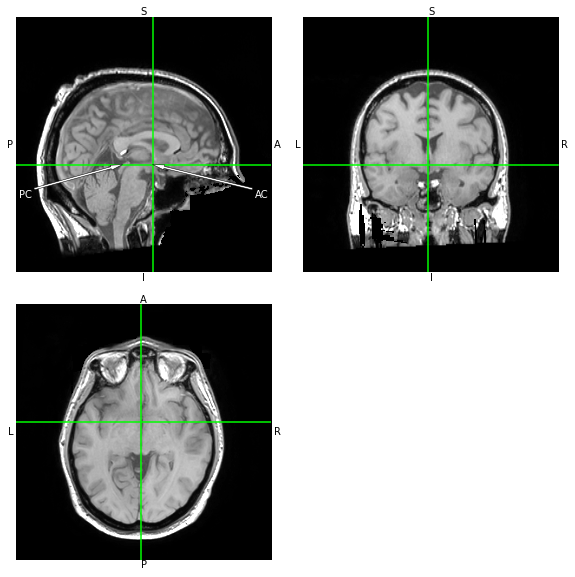

In [4]:
T1 = nib.load(op.join(misc_path, 'seeg', 'sample_seeg', 'mri', 'T1.mgz'))
viewer = T1.orthoview()
viewer.set_position(0, 9.9, 5.8)
viewer.figs[0].axes[0].annotate(
    'PC', (107, 108), xytext=(10, 75), color='white',
    horizontalalignment='center',
    arrowprops=dict(facecolor='white', lw=0.5, width=2, headwidth=5))
viewer.figs[0].axes[0].annotate(
    'AC', (137, 108), xytext=(246, 75), color='white',
    horizontalalignment='center',
    arrowprops=dict(facecolor='white', lw=0.5, width=2, headwidth=5))

## Freesurfer recon-all

The first step is the most time consuming; the freesurfer reconstruction.
This process segments out the brain from the rest of the MR image and
determines which voxels correspond to each brain area based on a template
deformation. This process takes approximately 8 hours so plan accordingly.

.. code-block:: bash

    $ export SUBJECT=sample_seeg
    $ export SUBJECTS_DIR=$MY_DATA_DIRECTORY
    $ recon-all -subjid $SUBJECT -sd $SUBJECTS_DIR \
      -i $MISC_PATH/seeg/sample_seeg_T1.mgz -all -deface

<div class="alert alert-info"><h4>Note</h4><p>You may need to include an additional ``-cw256`` flag which can be added
    to the end of the recon-all command if your MR scan is not
    ``256 x 256 x 256`` voxels.</p></div>

<div class="alert alert-info"><h4>Note</h4><p>Using the ``-deface`` flag will create a defaced, anonymized T1 image
    located at ``$MY_DATA_DIRECTORY/$SUBJECT/mri/orig_defaced.mgz``,
    which is helpful for when you publish your data. You can also use
    :func:`mne_bids.write_anat` and pass ``deface=True``.</p></div>



## Aligning the CT to the MR

Let's load our T1 and CT images and visualize them. You can hardly
see the CT, it's so misaligned that it is mostly out of view but there is a
part of the skull upsidedown and way off center in the middle plot.
Clearly, we need to align the CT to the T1 image.



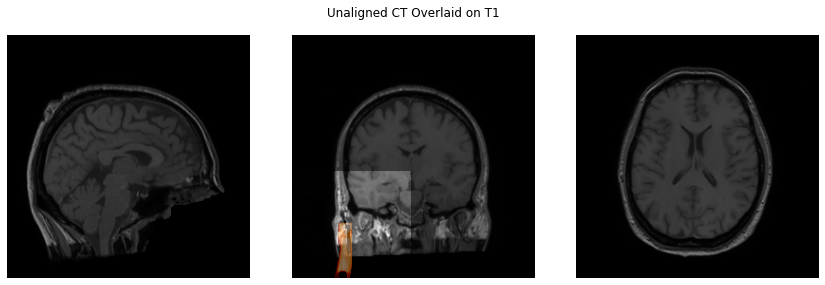

In [5]:
def plot_overlay(image, compare, title, thresh=None):
    """Define a helper function for comparing plots."""
    image = nib.orientations.apply_orientation(
        np.asarray(image.dataobj), nib.orientations.axcodes2ornt(
            nib.orientations.aff2axcodes(image.affine))).astype(np.float32)
    compare = nib.orientations.apply_orientation(
        np.asarray(compare.dataobj), nib.orientations.axcodes2ornt(
            nib.orientations.aff2axcodes(compare.affine))).astype(np.float32)
    if thresh is not None:
        compare[compare < np.quantile(compare, thresh)] = np.nan
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(title)
    for i, ax in enumerate(axes):
        ax.imshow(np.take(image, [image.shape[i] // 2], axis=i).squeeze().T,
                  cmap='gray')
        ax.imshow(np.take(compare, [compare.shape[i] // 2],
                          axis=i).squeeze().T, cmap='gist_heat', alpha=0.5)
        ax.invert_yaxis()
        ax.axis('off')
    fig.tight_layout()


CT_orig = nib.load(op.join(misc_path, 'seeg', 'sample_seeg_CT.mgz'))

# resample to T1's definition of world coordinates
CT_resampled = resample(moving=np.asarray(CT_orig.dataobj),
                        static=np.asarray(T1.dataobj),
                        moving_affine=CT_orig.affine,
                        static_affine=T1.affine)
plot_overlay(T1, CT_resampled, 'Unaligned CT Overlaid on T1', thresh=0.95)
del CT_resampled

Now we need to align our CT image to the T1 image.

We want this to be a rigid transformation (just rotation + translation),
so we don't do a full affine registration (that includes shear) here.
This takes a while (~10 minutes) to execute so we skip actually running it
here::

   reg_affine, _ = mne.transforms.compute_volume_registration(
        CT_orig, T1, pipeline='rigids')

And instead we just hard-code the resulting 4x4 matrix:



Applying affine registration ...
[done]


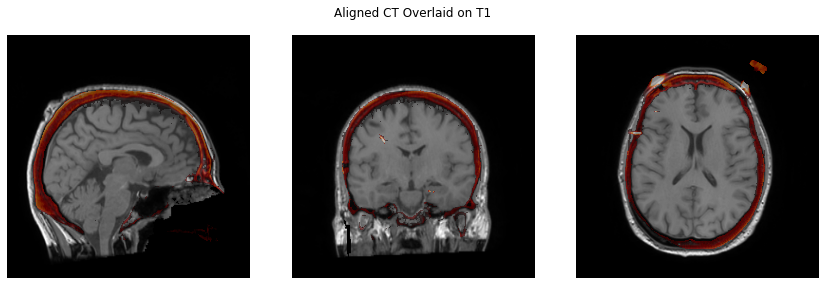

In [6]:
reg_affine = np.array([
    [0.99270756, -0.03243313, 0.11610254, -133.094156],
    [0.04374389, 0.99439665, -0.09623816, -97.58320673],
    [-0.11233068, 0.10061512, 0.98856381, -84.45551601],
    [0., 0., 0., 1.]])
CT_aligned = mne.transforms.apply_volume_registration(CT_orig, T1, reg_affine)
plot_overlay(T1, CT_aligned, 'Aligned CT Overlaid on T1', thresh=0.95)
del CT_orig

We can now see how the CT image looks properly aligned to the T1 image.

<div class="alert alert-info"><h4>Note</h4><p>The hyperintense skull is actually aligned to the hypointensity between
    the brain and the scalp. The brighter area surrounding the skull in the
    MR is actually subcutaneous fat.</p></div>



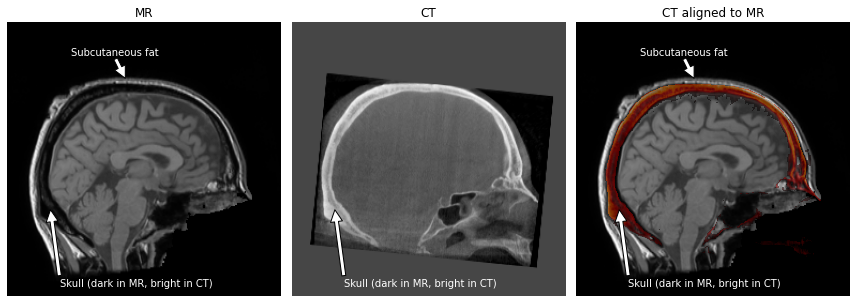

In [7]:
# make low intensity parts of the CT transparent for easier visualization
CT_data = CT_aligned.get_fdata().copy()
CT_data[CT_data < np.quantile(CT_data, 0.95)] = np.nan
T1_data = np.asarray(T1.dataobj)

fig, axes = plt.subplots(1, 3, figsize=(12, 6))
for ax in axes:
    ax.axis('off')
axes[0].imshow(T1_data[T1.shape[0] // 2], cmap='gray')
axes[0].set_title('MR')
axes[1].imshow(np.asarray(CT_aligned.dataobj)[CT_aligned.shape[0] // 2],
               cmap='gray')
axes[1].set_title('CT')
axes[2].imshow(T1_data[T1.shape[0] // 2], cmap='gray')
axes[2].imshow(CT_data[CT_aligned.shape[0] // 2], cmap='gist_heat', alpha=0.5)
for ax in (axes[0], axes[2]):
    ax.annotate('Subcutaneous fat', (110, 52), xytext=(100, 30),
                color='white', horizontalalignment='center',
                arrowprops=dict(facecolor='white'))
for ax in axes:
    ax.annotate('Skull (dark in MR, bright in CT)', (40, 175),
                xytext=(120, 246), horizontalalignment='center',
                color='white', arrowprops=dict(facecolor='white'))
axes[2].set_title('CT aligned to MR')
fig.tight_layout()
del CT_data, T1

Now we need to estimate the "head" coordinate transform.

MNE stores digitization montages in a coordinate frame called "head"
defined by fiducial points (origin is halfway between the LPA and RPA
see `tut-source-alignment`). For sEEG, it is convenient to get an
estimate of the location of the fiducial points for the subject
using the Talairach transform (see :func:`mne.coreg.get_mni_fiducials`)
to use to define the coordinate frame so that we don't have to manually
identify their location.



In [8]:
# estimate head->mri transform
subj_trans = mne.coreg.estimate_head_mri_t(
    'sample_seeg', op.join(misc_path, 'seeg'))

## Marking the Location of Each Electrode Contact

Now, the CT and the MR are in the same space, so when you are looking at a
point in CT space, it is the same point in MR space. So now everything is
ready to determine the location of each electrode contact in the
individual subject's anatomical space (T1-space). To do this, we can use the
MNE intracranial electrode location graphical user interface.

.. note: The most useful coordinate frame for intracranial electrodes is
         generally the ``surface RAS`` coordinate frame because that is
         the coordinate frame that all the surface and image files that
         Freesurfer outputs are in, see `tut-freesurfer-mne`. These are
         useful for finding the brain structures nearby each contact and
         plotting the results.

To operate the GUI:

  - Click in each image to navigate to each electrode contact
  - Select the contact name in the right panel
  - Press the "Mark" button or the "m" key to associate that
    position with that contact
  - Repeat until each contact is marked, they will both appear as circles
    in the plots and be colored in the sidebar when marked

  .. note:: The channel locations are saved to the ``raw`` object every time
            a location is marked or removed so there is no "Save" button.

  .. note:: Using the scroll or +/- arrow keys you can zoom in and out,
            and the up/down, left/right and page up/page down keys allow
            you to move one slice in any direction. This information is
            available in the help menu, accessible by pressing the "h" key.

  .. note:: If "Snap to Center" is on, this will use the radius so be
            sure to set it properly.



In [9]:
# load electrophysiology data to find channel locations for
# (the channels are already located in the example)
raw = mne.io.read_raw(op.join(misc_path, 'seeg', 'sample_seeg_ieeg.fif'))

gui = mne.gui.locate_ieeg(raw.info, subj_trans, CT_aligned,
                          subject='sample_seeg',
                          subjects_dir=op.join(misc_path, 'seeg'))
# The `raw` object is modified to contain the channel locations
# after closing the GUI and can now be saved
gui.close()  # close when done

Opening raw data file C:\Users\Jakda\mne_data\MNE-misc-data\seeg\sample_seeg_ieeg.fif...
    Range : 1310640 ... 1370605 =   1311.411 ...  1371.411 secs
Ready.
Using pyvistaqt 3d backend.



True

Let's do a quick sidebar and show what this looks like for ECoG as well.



In [10]:
T1_ecog = nib.load(op.join(misc_path, 'ecog', 'sample_ecog', 'mri', 'T1.mgz'))
CT_orig_ecog = nib.load(op.join(misc_path, 'ecog', 'sample_ecog_CT.mgz'))

# pre-computed affine from `mne.transforms.compute_volume_registration`
reg_affine = np.array([
    [0.99982382, -0.00414586, -0.01830679, 0.15413965],
    [0.00549597, 0.99721885, 0.07432601, -1.54316131],
    [0.01794773, -0.07441352, 0.99706595, -1.84162514],
    [0., 0., 0., 1.]])
# align CT
CT_aligned_ecog = mne.transforms.apply_volume_registration(
    CT_orig_ecog, T1_ecog, reg_affine)

raw_ecog = mne.io.read_raw(op.join(misc_path, 'ecog', 'sample_ecog_ieeg.fif'))
# use estimated `trans` which was used when the locations were found previously
subj_trans_ecog = mne.coreg.estimate_head_mri_t(
    'sample_ecog', op.join(misc_path, 'ecog'))
gui = mne.gui.locate_ieeg(raw_ecog.info, subj_trans_ecog, CT_aligned_ecog,
                          subject='sample_ecog',
                          subjects_dir=op.join(misc_path, 'ecog'))

Applying affine registration ...
[done]
Opening raw data file C:\Users\Jakda\mne_data\MNE-misc-data\ecog\sample_ecog_ieeg.fif...
    Range : 0 ... 112 =      0.000 ...     0.700 secs
Ready.


for ECoG, we typically want to account for "brain shift" or shrinking of the
brain away from the skull/dura due to changes in pressure during the
craniotomy
Note: this requires the BEM surfaces to have been computed e.g. using
`mne watershed_bem` or `mne flash_bem`.
First, let's plot the localized sensor positions without modification.



In [11]:
# plot projected sensors
brain_kwargs = dict(cortex='low_contrast', alpha=0.2, background='white')
brain = mne.viz.Brain('sample_ecog', subjects_dir=op.join(misc_path, 'ecog'),
                      title='Before Projection', **brain_kwargs)
brain.add_sensors(raw_ecog.info, trans=subj_trans_ecog)
view_kwargs = dict(azimuth=60, elevation=100, distance=350,
                   focalpoint=(0, 0, -15))
brain.show_view(**view_kwargs)

Channel types::	ecog: 320, seeg: 74


Now, let's project the sensors to the brain surface and re-plot them.



In [12]:
# project sensors to the brain surface
raw_ecog.info = mne.preprocessing.ieeg.project_sensors_onto_brain(
    raw_ecog.info, subj_trans_ecog, 'sample_ecog',
    subjects_dir=op.join(misc_path, 'ecog'))

# plot projected sensors
brain = mne.viz.Brain('sample_ecog', subjects_dir=op.join(misc_path, 'ecog'),
                      title='After Projection', **brain_kwargs)
brain.add_sensors(raw_ecog.info, trans=subj_trans_ecog)
brain.show_view(**view_kwargs)

RuntimeError: File does not exist: C:\Users\Jakda\mne_data\MNE-misc-data\ecog\sample_ecog\bem\brain.surf

The brain surface requires generating a BEM using `mne flash_bem` (if you have the FLASH scan) or `mne watershed_bem` (to use the T1)

Let's plot the electrode contact locations on the subject's brain.

MNE stores digitization montages in a coordinate frame called "head"
defined by fiducial points (origin is halfway between the LPA and RPA
see `tut-source-alignment`). For sEEG, it is convenient to get an
estimate of the location of the fiducial points for the subject
using the Talairach transform (see :func:`mne.coreg.get_mni_fiducials`)
to use to define the coordinate frame so that we don't have to manually
identify their location. The estimated head->mri ``trans`` was used
when the electrode contacts were localized so we need to use it again here.



In [ ]:
# plot the alignment
brain = mne.viz.Brain('sample_seeg', subjects_dir=op.join(misc_path, 'seeg'),
                      **brain_kwargs)
brain.add_sensors(raw.info, trans=subj_trans)
brain.show_view(**view_kwargs)

## Warping to a Common Atlas

Electrode contact locations are often compared across subjects in a template
space such as ``fsaverage`` or ``cvs_avg35_inMNI152``. To transform electrode
contact locations to that space, we need to determine a function that maps
from the subject's brain to the template brain. We will use the symmetric
diffeomorphic registration (SDR) implemented by ``Dipy`` to do this.

Before we can make a function to account for individual differences in the
shape and size of brain areas, we need to fix the alignment of the brains.
The plot below shows that they are not yet aligned.



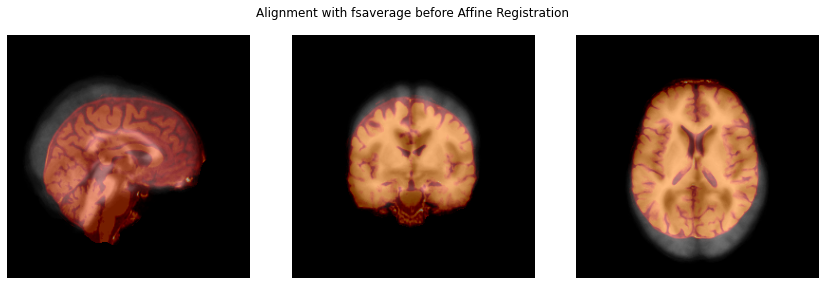

In [13]:
# load the subject's brain and the Freesurfer "fsaverage" template brain
subject_brain = nib.load(
    op.join(misc_path, 'seeg', 'sample_seeg', 'mri', 'brain.mgz'))
template_brain = nib.load(
    op.join(subjects_dir, 'fsaverage', 'mri', 'brain.mgz'))

plot_overlay(template_brain, subject_brain,
             'Alignment with fsaverage before Affine Registration')

Now, we'll register the affine of the subject's brain to the template brain.
This aligns the two brains, preparing the subject's brain to be warped
to the template.

<div class="alert alert-danger"><h4>Warning</h4><p>Here we use ``zooms=5`` just for speed, in general we recommend
             using ``zooms=None``` (default) for highest accuracy. To deal
             with this coarseness, we also use a threshold of 0.1 for the CT
             electrodes rather than 0.5. This coarse zoom and low threshold
             is useful for getting a quick view of the data, but finalized
             pipelines should use ``zooms=None`` instead!</p></div>



Computing registration...
Reslicing to zooms=(5.0, 5.0, 5.0) for translation ...
Optimizing translation:
    Optimizing level 2 [max iter: 10000]
    Optimizing level 1 [max iter: 1000]
    Optimizing level 0 [max iter: 100]
    Translation:    4.6 mm
    R²:            94.7%
Optimizing rigid:
    Optimizing level 2 [max iter: 10000]
    Optimizing level 1 [max iter: 1000]
    Optimizing level 0 [max iter: 100]
    Translation:    3.9 mm
    Rotation:      14.2°
    R²:            96.3%
Optimizing affine:
    Optimizing level 2 [max iter: 10000]
    Optimizing level 1 [max iter: 1000]
    Optimizing level 0 [max iter: 100]
    R²:            95.2%
Optimizing sdr:
    R²:            98.2%
Applying affine registration ...
Appling SDR warp ...
[done]


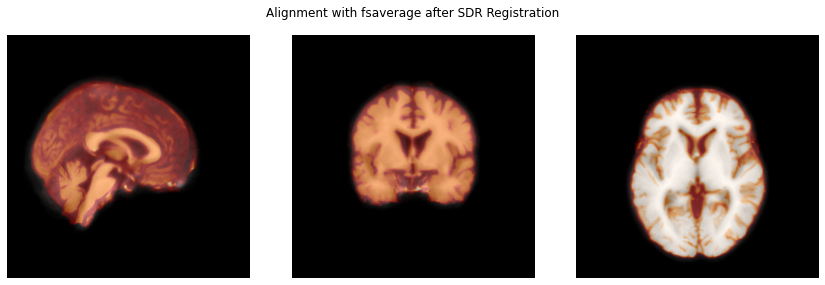

In [14]:
reg_affine, sdr_morph = mne.transforms.compute_volume_registration(
    subject_brain, template_brain, zooms=5, verbose=True)
subject_brain_sdr = mne.transforms.apply_volume_registration(
    subject_brain, template_brain, reg_affine, sdr_morph)

# apply the transform to the subject brain to plot it
plot_overlay(template_brain, subject_brain_sdr,
             'Alignment with fsaverage after SDR Registration')

del subject_brain, template_brain

Finally, we'll apply the registrations to the electrode contact coordinates.
The brain image is warped to the template but the goal was to warp the
positions of the electrode contacts. To do that, we'll make an image that is
a lookup table of the electrode contacts. In this image, the background will
be ``0`` s all the bright voxels near the location of the first contact will
be ``1`` s, the second ``2`` s and so on. This image can then be warped by
the SDR transform. We can finally recover a position by averaging the
positions of all the voxels that had the contact's lookup number in
the warped image.



Applying affine registration ...
Appling SDR warp ...
[done]


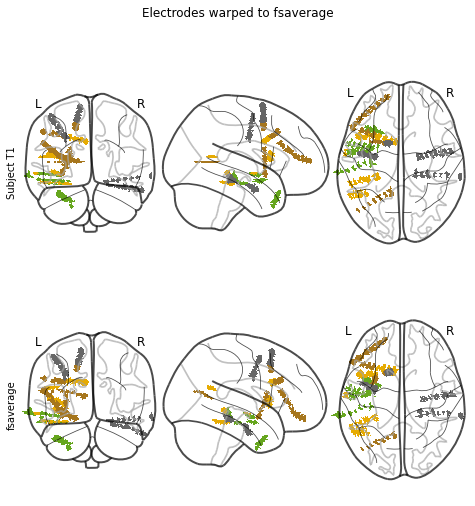

In [15]:
# first we need our montage but it needs to be converted to "mri" coordinates
# using our ``subj_trans``
montage = raw.get_montage()
montage.apply_trans(subj_trans)

# higher thresh such as 0.5 (default) works when `zooms=None`
montage_warped, elec_image, warped_elec_image = mne.warp_montage_volume(
    montage, CT_aligned, reg_affine, sdr_morph, thresh=0.1,
    subject_from='sample_seeg', subjects_dir_from=op.join(misc_path, 'seeg'),
    subject_to='fsaverage', subjects_dir_to=subjects_dir)

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
nilearn.plotting.plot_glass_brain(elec_image, axes=axes[0], cmap='Dark2')
fig.text(0.1, 0.65, 'Subject T1', rotation='vertical')
nilearn.plotting.plot_glass_brain(warped_elec_image, axes=axes[1],
                                  cmap='Dark2')
fig.text(0.1, 0.25, 'fsaverage', rotation='vertical')
fig.suptitle('Electrodes warped to fsaverage')

del CT_aligned

We can now plot the result. You can compare this to the plot in
`tut-working-with-seeg` to see the difference between this morph, which
is more complex, and the less-complex, linear Talairach transformation.
By accounting for the shape of this particular subject's brain using the
SDR to warp the positions of the electrode contacts, the position in the
template brain is able to be more accurately estimated.



In [16]:
# first we need to add fiducials so that we can define the "head" coordinate
# frame in terms of them (with the origin at the center between LPA and RPA)
montage_warped.add_estimated_fiducials('fsaverage', subjects_dir)

# compute the head<->mri ``trans`` now using the fiducials
template_trans = mne.channels.compute_native_head_t(montage_warped)

# now we can set the montage and, because there are fiducials in the montage,
# the montage will be properly transformed to "head" coordinates when we do
# (this step uses ``template_trans`` but it is recomputed behind the scenes)
raw.set_montage(montage_warped)

# plot the resulting alignment
brain = mne.viz.Brain('fsaverage', subjects_dir=subjects_dir, **brain_kwargs)
brain.add_sensors(raw.info, trans=template_trans)
brain.show_view(**view_kwargs)

Channel types::	seeg: 119


This pipeline was developed based on previous work
:footcite:`HamiltonEtAl2017`.



## References

.. footbibliography::

